# 数据分析全流程Notebook
本Notebook整合了数据处理、字段统计、变量构建、描述性统计与可视化、相关性分析等完整流程，内容来源于1~5号Python脚本。每一步均配有说明与可交互代码，便于理解和复用。

## 1. 数据主表处理与活跃博主筛选
本节对应脚本：1.Data Processing, Active Blogger Filtering and Report Association.py
- 读取主表数据，支持大文件高效处理
- 筛选活跃博主，清洗无效数据
- 可选择处理带货/不带货数据
- 多表关联，输出整合结果

In [3]:

# ---------------------------------------------
# 1.Data Processing, Active Blogger Filtering and Report Association.py
#
# 本脚本实现数据主表的高效读取、活跃博主筛选、数据清洗与多表关联，并最终输出整合结果。
# 可通过参数选择处理“带货”或“不带货”数据。
# 主要流程：
#   1.1 读取主表，进行恰当的解码以及格式初步处理，确保不出错且不占用过多内存。
#   1.2 去除无效数据，构建目标时长，筛选出主表中的活跃博主，进一步提高数据的有效性和可用性。
#   1.3 进行数据清洗与处理，选出带货/不带货数据，去除数据中的各色错误，着重修正时间格式，围绕主表按照各指标进行数据关联。
#   1.4 将多分区整合为单一文件并保存文件，方便后续的进一步处理与操作。
# ---------------------------------------------

import pandas as pd
import dask
import dask.dataframe as dd
from datetime import timedelta

# 选择处理带货或不带货数据
requirements = input('请选择处理类型（带货/不带货）: ').strip()

# 数据文件目录
file_path = r'.\data'

# 1.1 读取主表，进行恰当的解码以及格式初步处理，确保不出错且不占用过多内存。
video_data = dd.read_csv(
	file_path + r'\video_data.csv',
	encoding='GB18030',
	encoding_errors='ignore',
	usecols=[
		'category', 'author_id', 'name', 'title',
		'rid', 'comment', 'likes', 'share', 'duration', 'createtime',
		'product', 'sales', 'volume', 'aweme_url', 'collect_count',
		'download_count', 'forward_count', 'play_count', 'product_count',
	],
	dtype={
		'category': 'string', 'author_id': 'string', 'name': 'string', 'title': 'string',
		'rid': 'string', 'comment': 'string', 'likes': 'float32', 'share': 'float32', 'duration': 'float32',
		'product': 'string', 'sales': 'float32', 'volume': 'float32', 'aweme_url': 'string', 'collect_count': 'float32',
		'download_count': 'float32', 'forward_count': 'float32', 'play_count': 'float32', 'product_count': 'float32'
	}
)
print(video_data.head())

# 1.2 去除无效数据，构建目标时长，筛选出主表中的活跃博主，进一步提高数据的有效性和可用性。
video_data = video_data[~video_data['rid'].isnull()]
print(f"清除rid为空后的数据量: {len(video_data)}")

start_week_begin = pd.Timestamp('2023-06-05')
start_week_end = start_week_begin + timedelta(days=7)
end_week_begin = pd.Timestamp('2024-06-24')
end_week_end = end_week_begin + timedelta(days=7)

authors_info = dd.read_csv(file_path + r'\authors_info.csv', encoding='UTF-8')
print(authors_info['video_earliest_createtime'].head())

authors_info['video_earliest_createtime'] = dd.to_datetime(
	authors_info['video_earliest_createtime'],
	format='%Y-%m-%d %H:%M:%S',
	errors='coerce')
authors_info['video_latest_createtime'] = dd.to_datetime(
	authors_info['video_latest_createtime'],
	format='%Y-%m-%d %H:%M:%S',
	errors='coerce')

start_week_mask = (
	(authors_info['video_earliest_createtime'] >= start_week_begin) &
	(authors_info['video_earliest_createtime'] <= start_week_end)
)
end_week_mask = (
	(authors_info['video_latest_createtime'] >= end_week_begin) &
	(authors_info['video_latest_createtime'] <= end_week_end)
)

start_week_authors = authors_info.loc[start_week_mask, 'author_id'].unique()
end_week_authors = authors_info.loc[end_week_mask, 'author_id'].unique()
active_authors = set(start_week_authors) & set(end_week_authors)

print(f'活跃博主数量: {len(active_authors)}')
print('活跃博主ID示例:', list(active_authors)[:5])

active_mask = video_data['author_id'].isin(active_authors)
video_data = video_data[active_mask]

print('活跃博主数据示例:')
print(video_data.head())

# 1.3 进行数据清洗与处理，去除数据中的各色错误，着重修正时间格式，围绕主表按照各指标进行数据关联。
if requirements == '带货':
	# 仅保留带货视频
	video_data = video_data[video_data.sales != -2147483648]

	# 商品类目相关字段
	category_columns = [
		'v11_category_big', 'v11_category_big_id',
		'v11_category_first', 'v11_category_first_id',
		'v11_category_second', 'v11_category_second_id',
		'v11_category_third', 'v11_category_third_id',
		'v11_category_fourth', 'v11_category_fourth_id'
	]

	# 读取商品信息表，包含类目信息
	product_data = dd.read_csv(
		file_path + r'\product_data.csv',
		usecols=['volume_text', 'brand_name', 'product_id', 'product_title'] + category_columns,
		dtype={
			'volume_text': 'string', 'brand_name': 'string',
			'product_id': 'string', 'product_title': 'string',
			'v11_category_big': 'category',
			'v11_category_big_id': 'int16',
			'v11_category_first': 'category',
			'v11_category_first_id': 'int16',
			'v11_category_second': 'category',
			'v11_category_second_id': 'int16',
			'v11_category_third': 'category',
			'v11_category_third_id': 'int16',
			'v11_category_fourth': 'category',
			'v11_category_fourth_id': 'int16'
		}
	)

	# 清洗销量文本，去除异常字符并转为数值
	def clean_volume_text(text):
		if pd.isna(text):
			return 0
		text = str(text).replace(''', '').replace(''', '')
		text = text.replace(',', '')
		try:
			return float(text)
		except ValueError:
			return 0

	product_data['volume_numeric'] = product_data['volume_text'].map(clean_volume_text, meta=('volume_text', 'float32'))

	# 对每个商品标题，仅保留销量最大的记录，去重
	max_volume_per_title = product_data.groupby('product_title')['volume_numeric'].max().reset_index()
	product_data_deduplicated = product_data.merge(
		max_volume_per_title,
		on=['product_title', 'volume_numeric'],
		how='inner')

	# 主表与商品表关联，补充商品类目信息
	merged_dask = video_data.merge(
		product_data_deduplicated[['brand_name', 'product_id', 'product_title'] + category_columns],
		left_on='product',
		right_on='product_title',
		how='left'
	).drop(columns=['product_title'])

	print(merged_dask.head())

	# 读取粉丝趋势表
	fan_trend = dd.read_csv(file_path + r'\fan_trend.csv', encoding='UTF-8')

	# 转换时间格式并清洗异常，便于后续关联
	merged_dask['createtime'] = dd.to_datetime(
		merged_dask['createtime'],
		format='%Y/%m/%d %H:%M',
		errors='coerce')
	fan_trend['time_node'] = dd.to_datetime(
		fan_trend['time_node'],
		format='%Y-%m-%d %H:%M:%S',
		errors='coerce')
	merged_dask = merged_dask.assign(
		createtime=merged_dask['createtime'].astype('datetime64[ns]'))
	fan_trend = fan_trend.assign(
		time_node=fan_trend['time_node'].astype('datetime64[ns]'))

	# 提取日期部分，便于按天关联
	merged_dask['date_only'] = dd.to_datetime(merged_dask['createtime']).dt.date
	fan_trend['date_only'] = dd.to_datetime(fan_trend['time_node']).dt.date
	merged_dask = merged_dask.assign(
		date_only=merged_dask['date_only'].astype('datetime64[ns]'))
	fan_trend = fan_trend.assign(
		date_only=fan_trend['date_only'].astype('datetime64[ns]'))

	# 主表与粉丝趋势表按作者和日期关联，补充粉丝数
	merged_dask1 = merged_dask.merge(
		fan_trend[['cid', 'date_only', 'follower_count']],
		left_on=['author_id', 'date_only'],
		right_on=['cid', 'date_only'],
		how='left'
	).drop(columns=['cid', 'date_only'])

	print(merged_dask1.head())

	# 删除中间表，释放内存
	del merged_dask
	del video_data
	del product_data
	del fan_trend


	# 1.4 输出最终结果为单一CSV文件，便于后续分析
	merged_dask1.to_csv(file_path + '\\with_sales.csv', index=False, single_file=True)

else:
	# 仅保留不带货视频
	video_data = video_data[video_data.sales == -2147483648]

	# 读取粉丝趋势表
	fan_trend = dd.read_csv(file_path + r'\fan_trend.csv', encoding='UTF-8')

	# 转换时间格式并清洗异常，便于后续关联
	video_data['createtime'] = dd.to_datetime(
		video_data['createtime'],
		format='%Y/%m/%d %H:%M',
		errors='coerce')
	fan_trend['time_node'] = dd.to_datetime(
		fan_trend['time_node'],
		format='%Y-%m-%d %H:%M:%S',
		errors='coerce')
	video_data = video_data.assign(
		createtime=video_data['createtime'].astype('datetime64[ns]'))
	fan_trend = fan_trend.assign(
		time_node=fan_trend['time_node'].astype('datetime64[ns]'))

	# 提取日期部分，便于按天关联
	video_data['date_only'] = dd.to_datetime(video_data['createtime']).dt.date
	fan_trend['date_only'] = dd.to_datetime(fan_trend['time_node']).dt.date
	video_data = video_data.assign(
		date_only=video_data['date_only'].astype('datetime64[ns]'))
	fan_trend = fan_trend.assign(
		date_only=fan_trend['date_only'].astype('datetime64[ns]'))

	# 主表与粉丝趋势表按作者和日期关联，补充粉丝数
	merged_dask1 = video_data.merge(
		fan_trend[['cid', 'date_only', 'follower_count']],
		left_on=['author_id', 'date_only'],
		right_on=['cid', 'date_only'],
		how='left'
	).drop(columns=['cid', 'date_only'])

	print(merged_dask1.head())

	# 删除中间表，释放内存
	del video_data
	del fan_trend


	# 1.4 输出最终结果为单一CSV文件，便于后续分析
	merged_dask1.to_csv(file_path + '\\without_sales.csv', index=False, single_file=True)

print('数据处理完成。')

  category                         author_id  name              title  \
0       三农  YrKafmwdTVX7MX6xrZM0nziTGx_qcZPF  神兽许仙     #电影消失的她 取景地#灯塔   
1       三农  YrKafmwdTVX7MX6xrZM0nziTGx_qcZPF  神兽许仙             放羊娃#羊驼   
2       三农  YrKafmwdTVX7MX6xrZM0nziTGx_qcZPF  神兽许仙       今晚吃火锅 催催生#羊驼   
3       三农  YrKafmwdTVX7MX6xrZM0nziTGx_qcZPF  神兽许仙   土妞变模特#羊驼 #萌宠日常记录   
4       三农  YrKafmwdTVX7MX6xrZM0nziTGx_qcZPF  神兽许仙  美拉德羊驼 脸刹#羊驼 #直播片段   

                                rid comment   likes  share  duration  \
0  PpQ1pQeWRPR76lM1aooMqv6ggdJGHsOy      25   482.0   22.0   21036.0   
1  OY8cjBD1bDWuEGibqSnmxBbDNJTZUctg      22   535.0   53.0   30139.0   
2  h7VvO18dt-fijduGpMxKhpluxlUZ4Owt     187  4919.0  254.0  296355.0   
3  HSHuq9G0oFzGt3fpNxu2Qi69aPqwdp3r      84   736.0   70.0   86702.0   
4  0iK9xeUpw8D_hm_MWGs7TS0Vlu9CcyCc     186  1501.0  643.0  113173.0   

         createtime product         sales        volume  \
0   2023/7/16 10:50    <NA> -2.147484e+09 -2.147484e+09   
1    2023/

## 2. 字段统计分析
本节对应脚本：2.Field Statistics.py
- 对with_sales.csv和without_sales.csv进行字段级统计
- 统计唯一值、缺失值、常见取值等
- 结果输出为Excel，便于后续分析

In [4]:
import pandas as pd
import dask.dataframe as dd
from openpyxl import Workbook

# 读取数据
sales_data = dd.read_csv('./data/with_sales.csv', encoding='UTF-8', encoding_errors='ignore', assume_missing=True)
nosales_data = dd.read_csv('./data/without_sales.csv', encoding='UTF-8', encoding_errors='ignore', assume_missing=True)

# 字段统计分析函数
def analyze_column(column, col_name):
    unique_count = column.nunique().compute()
    null_count = column.isnull().sum().compute()
    total_count = len(column)
    non_null_count = total_count - null_count
    value_counts = column.value_counts().compute()
    top_10 = value_counts.sort_values(ascending=False).head(10)
    top_10_total = top_10.sum()
    top_10_percentage = top_10_total / non_null_count * 100 if non_null_count else 0
    other_total = non_null_count - top_10_total
    other_percentage = 100 - top_10_percentage if non_null_count else 0
    return {
        'column': col_name,
        'unique_count': unique_count,
        'null_count': null_count,
        'null_percentage': null_count / total_count * 100 if total_count else 0,
        'top_10_values': top_10.index.tolist(),
        'top_10_counts': top_10.values.tolist(),
        'top_10_percentages': (top_10.values / non_null_count * 100).tolist() if non_null_count else [],
        'other_total': other_total,
        'other_percentage': other_percentage
    }

# 分析所有列
results_nosales = [analyze_column(nosales_data[col], col) for col in nosales_data.columns]
results_sales = [analyze_column(sales_data[col], col) for col in sales_data.columns]

# 转为DataFrame
nosales_result = pd.DataFrame(results_nosales)
sales_result = pd.DataFrame(results_sales)

# 写入Excel
def write_result_to_excel(df, excel_path):
    wb = Workbook()
    default_sheet = wb.active
    wb.remove(default_sheet)
    for idx, row in df.iterrows():
        sheet_name = str(row['column'])[:31] if str(row['column']) else f'Sheet{idx+1}'
        ws = wb.create_sheet(title=sheet_name)
        ws['A1'] = row['column']
        ws['A2'] = '唯一值数量'
        ws['B2'] = row['unique_count']
        ws['A3'] = '空值数量'
        ws['B3'] = row['null_count']
        ws['C3'] = row['null_percentage']
        for i in range(10):
            ws[f'A{4+i}'] = row['top_10_values'][i] if i < len(row['top_10_values']) else ''
            ws[f'B{4+i}'] = row['top_10_counts'][i] if i < len(row['top_10_counts']) else ''
            ws[f'C{4+i}'] = row['top_10_percentages'][i] if i < len(row['top_10_percentages']) else ''
        ws['A15'] = '其他取值'
        ws['B15'] = row['other_total']
        ws['C15'] = row['other_percentage']
    wb.save(excel_path)

write_result_to_excel(sales_result, './data/sales_TOP10.xlsx')
write_result_to_excel(nosales_result, './data/nosales_TOP10.xlsx')

## 3. 变量构建
本节对应脚本：3.Variable Construction.py
- 针对带货/不带货样本，构建结果变量、前因变量、调节变量、控制变量等
- 变量包括：播放量、销量、转化率、时间段、是否周末、影响力规模、产品类型、时长等
- 输出变量结果为CSV文件，便于后续分析

In [5]:
import pandas as pd
import dask.dataframe as dd

# 读取数据
sales_data = dd.read_csv('./data/with_sales.csv', encoding='UTF-8', encoding_errors='ignore', assume_missing=True)
nosales_data = dd.read_csv('./data/without_sales.csv', encoding='UTF-8', encoding_errors='ignore', assume_missing=True)

# 带货样本变量构建
sales_data['播放量'] = sales_data['play_count']
sales_data['销量'] = sales_data['sales']
sales_data['点赞'] = sales_data['likes']
sales_data['评论'] = sales_data['comment']
sales_data['分享'] = sales_data['share']
sales_data['销售转化率'] = sales_data['sales'] / sales_data['play_count'].replace(0, None)
sales_data['点赞转化率'] = sales_data['likes'] / sales_data['play_count'].replace(0, None)
sales_data['评论转化率'] = sales_data['comment'] / sales_data['play_count'].replace(0, None)
sales_data['分享转化率'] = sales_data['share'] / sales_data['play_count'].replace(0, None)

# 时间段变量
sales_data['createtime'] = dd.to_datetime(sales_data['createtime'], errors='coerce')
def get_time_period(dt):
    hour = dt.hour if not pd.isnull(dt) else -1
    if 6 <= hour < 12: return '上午'
    elif 12 <= hour < 18: return '下午'
    elif 18 <= hour < 24: return '晚上'
    elif 0 <= hour < 6: return '深夜'
    else: return '未知'
sales_data['时间段'] = sales_data['createtime'].map(get_time_period, meta=('createtime', 'object'))

# 是否周末变量
def is_weekend(dt):
    if pd.isnull(dt): return -1
    return 1 if dt.weekday() >= 5 else 0
sales_data['是否周末'] = sales_data['createtime'].map(is_weekend, meta=('createtime', 'int8'))

# 影响力规模分组
def influencer_size(fans):
    if pd.isnull(fans): return -1
    try: fans = float(fans)
    except: return -1
    if fans < 10000: return 0
    elif fans < 50000: return 1
    elif fans < 1000000: return 2
    elif fans < 5000000: return 3
    else: return 4
sales_data['影响力规模'] = sales_data['follower_count'].map(influencer_size, meta=('follower_count', 'int8'))

# 产品类型、时长
sales_data['产品类型'] = sales_data['v11_category_big']
sales_data['时长'] = sales_data['duration']

# 保存带货变量结果
save_columns_sales = [
    'category', 'author_id', 'name', 'title', 'rid', 'product', 'aweme_url',
    '播放量', '销量', '点赞', '评论', '分享',
    '销售转化率', '点赞转化率', '评论转化率', '分享转化率',
    'createtime', '时间段', '是否周末', '影响力规模', '产品类型', '时长'
    ]
sales_data[save_columns_sales].compute().to_csv('./data/带货数据变量指标.csv', index=False, encoding='utf-8-sig')

# 不带货样本变量构建
nosales_data['播放量'] = nosales_data['play_count']
nosales_data['点赞'] = nosales_data['likes']
nosales_data['评论'] = nosales_data['comment']
nosales_data['分享'] = nosales_data['share']
nosales_data['点赞转化率'] = nosales_data['likes'] / nosales_data['play_count'].replace(0, None)
nosales_data['评论转化率'] = nosales_data['comment'] / nosales_data['play_count'].replace(0, None)
nosales_data['分享转化率'] = nosales_data['share'] / nosales_data['play_count'].replace(0, None)
nosales_data['createtime'] = dd.to_datetime(nosales_data['createtime'], errors='coerce')
nosales_data['时间段'] = nosales_data['createtime'].map(get_time_period, meta=('createtime', 'object'))
nosales_data['是否周末'] = nosales_data['createtime'].map(is_weekend, meta=('createtime', 'int8'))
nosales_data['影响力规模'] = nosales_data['follower_count'].map(influencer_size, meta=('follower_count', 'int8'))
nosales_data['时长'] = nosales_data['duration']

# 保存不带货变量结果
save_columns_nosales = [
    'category', 'author_id', 'name', 'title', 'rid', 'aweme_url',
    '播放量', '点赞', '评论', '分享',
    '点赞转化率', '评论转化率', '分享转化率',
    'createtime', '时间段', '是否周末', '影响力规模', '时长'
    ]
nosales_data[save_columns_nosales].compute().to_csv('./data/不带货数据变量指标.csv', index=False, encoding='utf-8-sig')

## 4. 描述性统计与可视化对比
本节对应脚本：4.Descriptive Statistics.py
- 对带货/不带货变量数据进行均值、中位数、方差等统计
- 生成小时、星期分布、变量分布、产品类型频次等可视化图片
- 统计表与图片写入Excel，便于后续分析

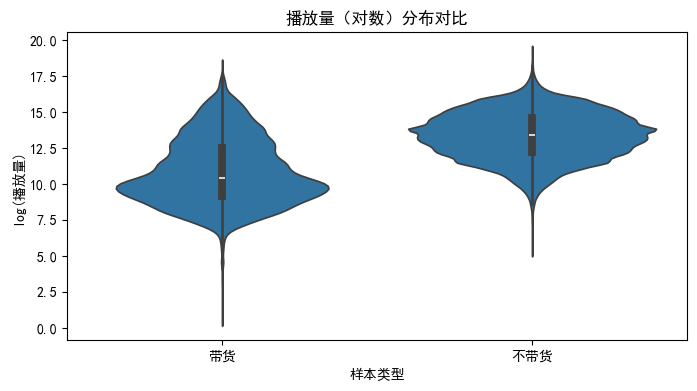

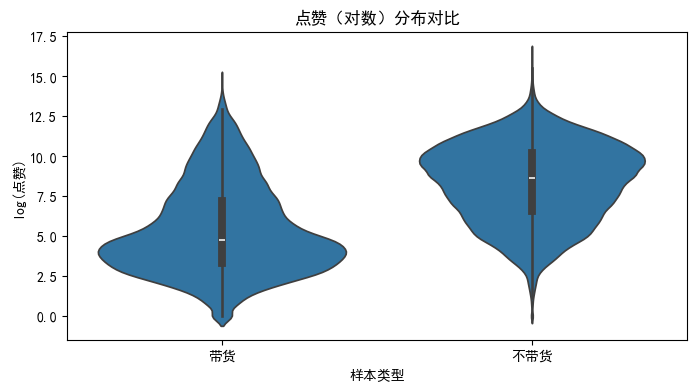

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
matplotlib.rcParams['axes.unicode_minus'] = False

# 读取变量数据
sales_df = pd.read_csv('./data/带货数据变量指标.csv', encoding='utf-8-sig')
nosales_df = pd.read_csv('./data/不带货数据变量指标.csv', encoding='utf-8-sig')

# 描述性统计
sales_numeric_cols = ['播放量', '销量', '点赞', '评论', '分享', '销售转化率', '点赞转化率', '评论转化率', '分享转化率', '时长']
nosales_numeric_cols = ['播放量', '点赞', '评论', '分享', '点赞转化率', '评论转化率', '分享转化率', '时长']

def describe_numeric(df, cols):
    desc = df[cols].agg(['mean', 'median', 'var', 'max', 'min', 'count']).T
    desc = desc.rename(columns={'mean': '均值', 'median': '中位数', 'var': '方差', 'max': '最大值', 'min': '最小值', 'count': '样本数量'})
    return desc

sales_desc = describe_numeric(sales_df, sales_numeric_cols)
nosales_desc = describe_numeric(nosales_df, nosales_numeric_cols)

# 对数变换后的小提琴图
log_vars = ['播放量', '点赞'] #省略销量、分享等前因变量
for var in log_vars:
    # 合并数据并去除非正值
    sales_tmp = sales_df[[var]].copy()
    sales_tmp['样本类型'] = '带货'
    nosales_tmp = nosales_df[[var]].copy()
    nosales_tmp['样本类型'] = '不带货'
    plot_df = pd.concat([sales_tmp, nosales_tmp], axis=0)
    plot_df = plot_df[plot_df[var] > 0]
    plot_df[var+'_log'] = np.log(plot_df[var])
    plt.figure(figsize=(8,4))
    sns.violinplot(data=plot_df, x='样本类型', y=var+'_log')
    plt.title(f'{var}（对数）分布对比')
    plt.ylabel(f'log({var})')
    plt.show()

## 5. 相关性分析与分布对比
本节对应脚本：5.Correlation Analysis.py
- 计算带货/不带货样本的相关系数表，显著性标注
- 生成分组变量与结果变量的分布对比图
- 相关系数表与分布图片写入Excel，便于后续分析

In [20]:
import pandas as pd
from scipy.stats import pearsonr
import numpy as np

# 读取变量数据
sales = pd.read_csv('./data/带货数据变量指标.csv', encoding='utf-8-sig')
nosales = pd.read_csv('./data/不带货数据变量指标.csv', encoding='utf-8-sig')

# 相关系数计算函数
def calc_corr_table(df, cause_vars, result_vars):
    cat_vars = [v for v in ['时间段', '影响力规模', '产品类型'] if v in cause_vars and v in df.columns]
    if cat_vars:
        df_encoded = pd.get_dummies(df[cause_vars], columns=cat_vars, dummy_na=True, drop_first=True)
    else:
        df_encoded = df[cause_vars].copy()
    df_all = pd.concat([df_encoded, df[result_vars]], axis=1)
    df_all = df_all.apply(pd.to_numeric, errors='coerce')
    corr_table = pd.DataFrame(index=df_encoded.columns, columns=result_vars)
    pval_table = pd.DataFrame(index=df_encoded.columns, columns=result_vars)
    for c in df_encoded.columns:
        for r in result_vars:
            x = df_all[c]
            y = df_all[r]
            mask = x.notnull() & y.notnull()
            if mask.sum() > 2:
                corr, pval = pearsonr(x[mask], y[mask])
                corr_table.loc[c, r] = corr
                pval_table.loc[c, r] = pval
            else:
                corr_table.loc[c, r] = np.nan
                pval_table.loc[c, r] = np.nan
    def mark_sig(c, p):
        if pd.isnull(c): return ''
        if p < 0.01: return f'{c:.2f}**'
        elif p < 0.05: return f'{c:.2f}*'
        else: return f'{c:.2f}'
    sig_table = corr_table.copy()
    for c in corr_table.index:
        for r in corr_table.columns:
            sig_table.loc[c, r] = mark_sig(corr_table.loc[c, r], pval_table.loc[c, r])
    return sig_table

# 变量定义
result_vars_sales = ['播放量', '销量', '点赞', '评论', '分享', '销售转化率', '点赞转化率', '评论转化率', '分享转化率']
cause_vars_sales = ['是否周末', '时长', '影响力规模'] #省略影响力规模等前因变量
result_vars_nosales = ['播放量', '点赞', '评论', '分享', '点赞转化率', '评论转化率', '分享转化率']
cause_vars_nosales = ['是否周末', '时长', '影响力规模'] #省略影响力规模等前因变量

# 计算相关系数表
corr_sales = calc_corr_table(sales, cause_vars_sales, result_vars_sales)
corr_nosales = calc_corr_table(nosales, cause_vars_nosales, result_vars_nosales)

# 显示带货样本相关系数表
print(corr_sales)
print(corr_nosales)

              播放量       销量      点赞      评论      分享    销售转化率    点赞转化率    评论转化率  \
是否周末        0.01*   -0.01*    0.00   -0.00    0.01     0.00     0.00    -0.00   
时长         0.05**   0.02**  0.05**  0.02**  0.02**    -0.00   0.04**     0.01   
影响力规模_3.0   -0.00  -0.02**  0.02**    0.01   -0.01  -0.02**   0.03**  -0.05**   
影响力规模_4.0  0.03**   0.03**    0.00   0.01*  0.02**     0.01  -0.03**   0.06**   
影响力规模_nan                                                                       

             分享转化率  
是否周末          0.01  
时长         -0.02**  
影响力规模_3.0  -0.04**  
影响力规模_4.0   0.04**  
影响力规模_nan           
               播放量       点赞       评论       分享    点赞转化率    评论转化率    分享转化率
是否周末          0.00   0.01**     0.00     0.00     0.00     0.00    -0.00
时长         -0.01**  -0.01**    -0.00   -0.01*  -0.05**  -0.01**  -0.01**
影响力规模_1.0  -0.01**   -0.01*    -0.00    -0.00   0.01**     0.00     0.00
影响力规模_2.0  -0.10**  -0.06**  -0.03**  -0.01**   0.02**    0.01*   0.02**
影响力规模_3.0   0.01**   0

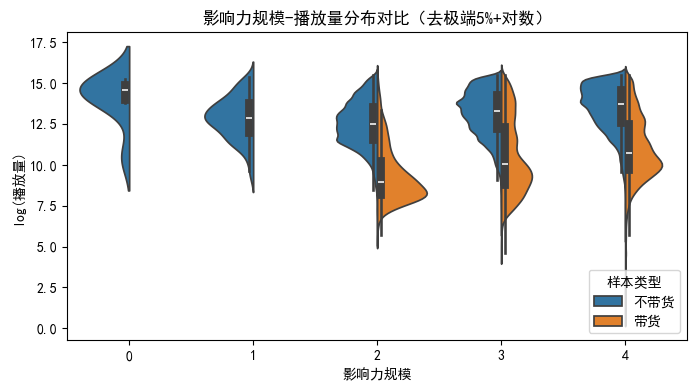

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# 分组变量与结果变量分布对比图（批量生成，风格贴近5号脚本）
group_vars = ['影响力规模']  # 可扩展为['category', '时间段', '是否周末', '影响力规模']
result_vars = ['播放量']  # 可扩展为所有结果变量

def plot_group_result_violin_all(groups, results):
    for group in groups:
        for result in results:
            df1 = sales[[group, result]].copy() if (group in sales.columns and result in sales.columns) else None
            df2 = nosales[[group, result]].copy() if (group in nosales.columns and result in nosales.columns) else None
            if df1 is not None: df1['样本类型'] = '带货'
            if df2 is not None: df2['样本类型'] = '不带货'
            plot_df = pd.concat([df1, df2], axis=0) if (df1 is not None or df2 is not None) else None
            if plot_df is not None and not plot_df.empty:
                # 去极端值
                q_low = plot_df[result].quantile(0.05)
                q_high = plot_df[result].quantile(0.95)
                plot_df = plot_df[(plot_df[result] >= q_low) & (plot_df[result] <= q_high)]
                # 对数变换（如需）
                plot_df = plot_df[plot_df[result] > 0]
                plot_df[result+'_log'] = np.log(plot_df[result])
                plt.figure(figsize=(8,4))
                sns.violinplot(x=group, y=result+'_log', hue='样本类型', data=plot_df, split=True, inner='box')
                plt.title(f'{group}-{result}分布对比（去极端5%+对数）')
                plt.ylabel(f'log({result})')
                plt.show()

# 示例：影响力规模-播放量分布对比
plot_group_result_violin_all(['影响力规模'], ['播放量'])